# COMP5328 - Advanced Machine Learning
## Assignment 1: NMF Algorithms – Code

---

# 1. Import Libraries
- 导入 numpy, scipy, matplotlib
- （如果需要）导入 sklearn 用于评估指标
- 设置随机种子，保证结果可复现

---

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from fontTools.misc.cython import returns
from imageio.core import Array
from skimage.util import random_noise
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
from scipy.optimize import linear_sum_assignment
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




# 2. Load Datasets
## 2.1 YaleB Dataset
- 加载 ORL 图像数据
- reshape 成矩阵 V
- 归一化 (0-1)

[0.5386985  0.55660033 0.56707025 ... 0.43386093 0.5125867  0.5530663 ]
[ 0  0  0 ... 37 37 37]


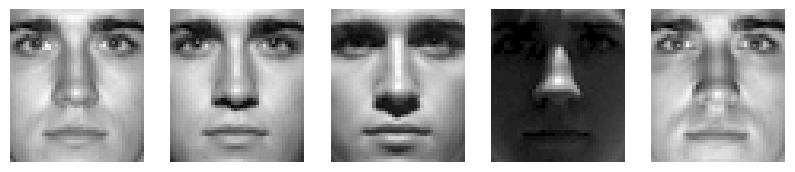

In [51]:
def load_data(root='data/CroppedYaleB', reduce=4):
    images, labels = [], []
    for i, person in enumerate(os.listdir(root)):
        person_dir = os.path.join(root, person)
        if not os.path.isdir(person_dir):
            continue
        for file_name in sorted(os.listdir(person_dir)):
            if file_name.endswith('Ambient.pgm'):
                continue
            if not file_name.endswith('.pgm'):
                continue
            img = Image.open(os.path.join(person_dir, file_name)).convert('L')
            w, h = img.size
            img_resized = img.resize([s//reduce for s in img.size])

            # convert to np array
            img_np = np.array(img_resized, dtype=np.uint8)

            # preprocessing
            # highlight the shadow

            img_np = np.asarray(img_np, dtype=np.float32) / 255.0
            gamma = 0.5
            img_np = np.power(img_np, gamma)

            img_flat = np.asarray(img_np).reshape((-1,1))

            # collect data and label.
            images.append(img_flat)
            labels.append(i)


    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    return images, labels

images_YaleB, labels_YaleB = load_data()
# the images have been scaled to 0, 1
print(images_YaleB[:, 0])
print(labels_YaleB[:])
# demonstrate the first 5 images.
plt.figure(figsize=(10,10))
for i in range(5):
    img0 = images_YaleB[:, i]
    img0 = np.reshape(img0, (192//4, 168//4))
    plt.subplot(1,5, i + 1)
    plt.axis('off')
    plt.imshow(img0, cmap='gray')


plt.axis('off')
plt.show()


## 2.2 Load ORL Dataset

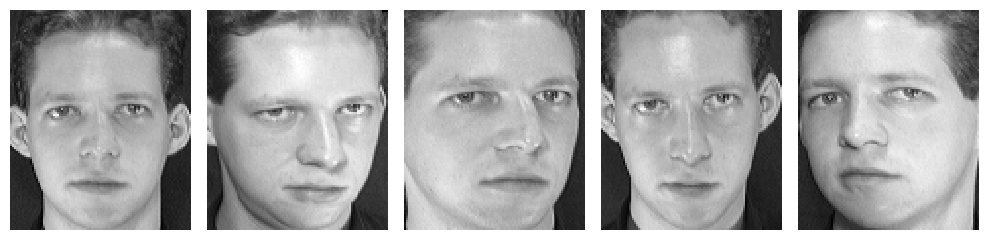

In [19]:
def load_orl_data(root="./data/ORL", reduce=1):

    image_cols, label_list = [], []

    for idx, person_name in enumerate(sorted(os.listdir(root))):
        person_path = os.path.join(root, person_name)
        if not os.path.isdir(person_path):
            continue

        for fname in sorted(os.listdir(person_path)):
            if not fname.lower().endswith(".pgm"):
                continue
            img_path = os.path.join(person_path, fname)
            img = Image.open(img_path).convert("L")
            if reduce != 1:
                w, h = img.size
                img = img.resize((w // reduce, h // reduce))

            arr = np.asarray(img, dtype=np.float32) / 255.0
            image_cols.append(arr.reshape(-1, 1))
            label_list.append(idx)

    images = np.concatenate(image_cols, axis=1)
    labels = np.array(label_list, dtype=int)
    return images, labels

# Read data
images, labels = load_orl_data(root="./data/ORL", reduce=1)

# Display the first 10 images
plt.figure(figsize=(10, 2.5))
for i in range(5):
    img_matrix = images[:, i].reshape(112, 92)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_matrix, cmap='gray', interpolation='nearest')
    plt.axis("off")

plt.tight_layout()
plt.show()


# 3. Noise Generation
## 3.1 Salt & Pepper Noise

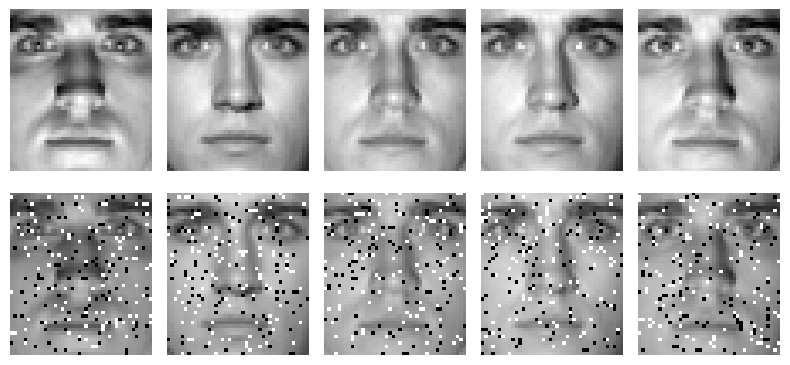

In [52]:
# Adding salt and pepper noise
def aad_salt_pepper_noise(imgs: np.ndarray, p = 0.1, r = 0.5):
    noisy_img = np.copy(imgs)
    for i in range(noisy_img.shape[1]):
        length = noisy_img.shape[0]

        # noisy_img = img.copy()
        # height, weight = img.shape
        # pixels_cnt = height * weight

        # the count of noisy
        noisy_cnt = int(p * length)

        # choosing the pixels randomly
        coordinates = np.random.choice(length, size=noisy_cnt, replace=False)

        # setting the salt
        salt_cnt = int(r * noisy_cnt)
        salt_idx = coordinates[:salt_cnt]
        noisy_img[salt_idx, i] = 1.0

        pepper_cnt = coordinates[salt_cnt:]
        noisy_img[pepper_cnt, i] = 0.0

    return noisy_img

# adding noisy to all the images
noisy_img = aad_salt_pepper_noise(images_YaleB, 0.1, 0.5)

# visualization
n = 5
h, w = (192//4, 168//4)
plt.figure(figsize=(8,4))
for i in range(n):
    # clean
    clean = images_YaleB[:, i + 5].reshape(h, w)
    ax1 = plt.subplot(2, n, i + 1)
    ax1.imshow(clean, cmap='gray')
    ax1.axis('off')
    if i == 0:
        plt.ylabel("Clean", fontsize=12)

    # after adding noisy
    noisy = noisy_img[:, i + 5].reshape(h, w)
    plt.subplot(2, n, n + i + 1)
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Noisy", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Custom Noise



# 4. NMF Algorithms Implementation (Core)
## 4.1 Standard NMF (Baseline)
- 目标函数：L2 范数
- 优化方法：乘法更新规则 (MU) 或交替最小二乘 (ALS)
- 函数：`nmf_standard(V, rank, max_iter)`

In [23]:
# The standard NMF algorithm
def nmf_standard(V, rank = 40, max_iter = 200, tol = 1e-4, seed = 0, verbose = True):
    np.random.seed(seed)
    m, n = V.shape
    W = np.random.rand(m, rank)
    H = np.random.rand(rank, n)

    # store the loss to draw the variance of loss
    loss_history = []

    # prevent to divide 0
    eps = 1e-9

    for it in range(max_iter):
        # update H
        H = H * (W.T @ V) / (W.T @ W @ H + eps)
        # update W
        W = W * (V @ H.T) / (W @ H @ H.T + eps)
        V_hat = W @ H

        loss = np.linalg.norm(V - V_hat, 'fro')
        loss_history.append(loss)

        if verbose and it % 50 == 0:
            print(f'iter = {it}, loss = {loss:.4f}')

        # if there is no change in new iter pause the training
        if it > 1 and abs(loss_history[-2] -loss) < tol:
            break

    return W, H, loss_history



## 4.2 Robust NMF (L1 / L2,1 Variant)
- 目标函数：L1 或 L2,1 范数
- 优化方法：子梯度 / 加权更新
- 函数：`nmf_robust(V, rank, max_iter)`

---

In [59]:
def nmf_robust(V, rank=40, regular=1, lam=0.0, max_iter=200, tol=1e-4, seed = 0, verbose=True):
    np.random.seed(seed)

    eps = 1e-10
    rng = np.random.RandomState(seed)
    m, n = V.shape
    W = np.abs(rng.randn(m, rank))
    H = np.abs(rng.randn(rank, n))

    loss_history = []

    for it in range(max_iter):
        R = V - W @ H

        # For L1 regularization
        if regular == 1:
            P = 1.0 / (np.abs(R) + eps)
            # Update H
            num_H = W.T @ (P * V)
            den_H = W.T @ (P * (W @ H)) + lam*H + eps
            H *= num_H / den_H
            H = np.maximum(H, 0.0)

            # Update W
            num_W = (P * V) @ H.T
            den_W = (P * (W @ H)) @ H.T + lam*W + eps
            W *= num_W / den_W
            W = np.maximum(W, 0.0)
            # monitor

            V_hat = W @ H
            loss = np.linalg.norm(V - V_hat, 'fro')
            loss_history.append(loss)

        # For L2 regularization
        elif regular == 2:
            col_norm = np.sqrt((R**2).sum(axis=0)) + eps
            d = 0.5 / col_norm
            # Update H
            num_H = W.T @ (V * d)
            den_H = W.T @ ( (W @ H) * d ) + lam*H + eps
            H *= num_H / den_H
            H = np.maximum(H, 0.0)

            # Update W
            num_W = (V * d) @ H.T
            den_W = ((W @ H) * d) @ H.T + lam*W + eps
            W *= num_W / den_W
            W = np.maximum(W, 0.0)

            V_hat = W @ H
            loss = np.linalg.norm(V - V_hat, 'fro')
            loss_history.append(loss)

        if verbose and it % 50 == 0:
            print(f"[Robust NMF - L1] iter={it:3d}, loss={loss:.6f}")

        # if there is no change in new iter pause the training
        if it > 1 and abs(loss_history[-2] -loss) < tol:
            break
    return W, H, loss_history



# 5. Evaluation Metrics
## 5.1 Relative Reconstruction Error (RRE)

In [45]:
def compute_ree(V, W, H):
    V_hat = W @ H
    return np.linalg.norm(V - V_hat, 'fro') / np.linalg.norm(V, 'fro')

## 5.2 Accuracy
- 使用 KMeans 聚类
- 计算聚类标签 vs 真实标签
- 函数：`compute_accuracy(Y_true, Y_pred)`

In [46]:
# Compute accuracy by K-means
def compute_acc(Y: np.ndarray, H, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0, n_init=50).fit(H.T)
    Y_pred = km.labels_
    # Hungarian
    D = max(Y_pred.max(), Y.max()) + 1
    cost = np.zeros((D, D))
    for i in range(len(Y_pred)):
        # calculate how many labels are matched
        cost[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(cost.max() - cost)
    return sum(cost[i, j] for i, j in zip(row, col)) / len(Y_pred)

## 5.3 Normalized Mutual Information (Optional)
- 使用 sklearn.metrics
- 函数：`compute_nmi(Y_true, Y_pred)`

---


# 6. Experiments
## 6.1 Run NMF on ORL Dataset
- 在 ORL 数据集上分别跑标准 NMF 和鲁棒 NMF
- 保存结果


## 6.2 Run NMF on YaleB Dataset
- 在 YaleB 数据集上分别跑标准 NMF 和鲁棒 NMF
- 保存结果

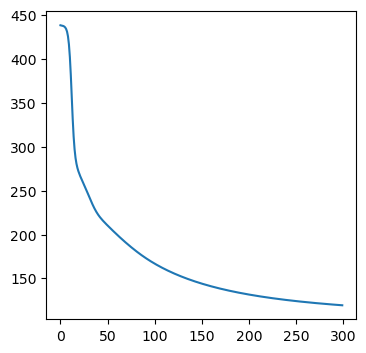

REE in clean data = 0.1037
Acc in clean data = 0.2444


In [38]:
# Train W H of the NMF algorithm on the YaleB
result = nmf_robust_l1(images_YaleB, max_iter=300, rank=100, verbose=False)
W, H, loss_list = result

K = len(np.unique(labels_YaleB))
# print("unique labels:", K)
# Ree
REE = compute_ree(images_YaleB, result[0], result[1])
# Accuracy
Acc = compute_acc(labels_YaleB, result[1], K)

plt.figure(figsize=(4, 4))
plt.plot(loss_list)
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('Loss plot of standard NMF')
plt.tight_layout()
plt.show()
plt.figure(figsize=(4, 4))
plt.show()

print("REE in clean data = {:.4f}".format(REE))
print("Acc in clean data = {:.4f}".format(Acc))

[Robust NMF - L1] iter=  0, loss=440.805642
[Robust NMF - L1] iter= 50, loss=215.766906
[Robust NMF - L1] iter=100, loss=171.561943
[Robust NMF - L1] iter=150, loss=147.906356
[Robust NMF - L1] iter=200, loss=134.860751
[Robust NMF - L1] iter=250, loss=126.967046
[Robust NMF - L1] iter=300, loss=121.853720
[Robust NMF - L1] iter=350, loss=118.325353
[Robust NMF - L1] iter=400, loss=115.763162
[Robust NMF - L1] iter=450, loss=113.831294
[Robust NMF - L1] iter=500, loss=112.331632
[Robust NMF - L1] iter=550, loss=111.136628


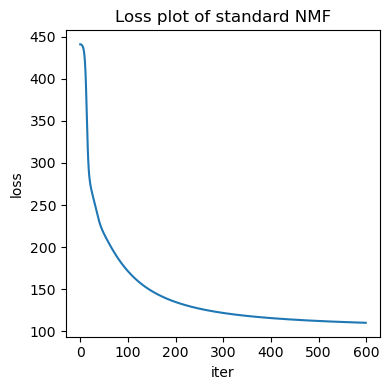

<Figure size 400x400 with 0 Axes>

REE in clean data = 0.0956
Acc in clean data = 0.3041


In [58]:
# Train W H of the L2 NMF algorithm on the YaleB
result = nmf_robust(images_YaleB, regular = 2,  max_iter=600, rank=100, verbose=True)
W, H, loss_list = result

K = len(np.unique(labels_YaleB))
# print("unique labels:", K)
# Ree
REE = compute_ree(images_YaleB, result[0], result[1])
# Accuracy
Acc = compute_acc(labels_YaleB, result[1], K)

plt.figure(figsize=(4, 4))
plt.plot(loss_list)
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('Loss plot of standard NMF')
plt.tight_layout()
plt.show()
plt.figure(figsize=(4, 4))
plt.show()

print("REE in clean data = {:.4f}".format(REE))
print("Acc in clean data = {:.4f}".format(Acc))

Accuracy in noised data: mean = 0.1519, std = 0.0547
REE in noised data mean = 0.4099, std = 0.0583


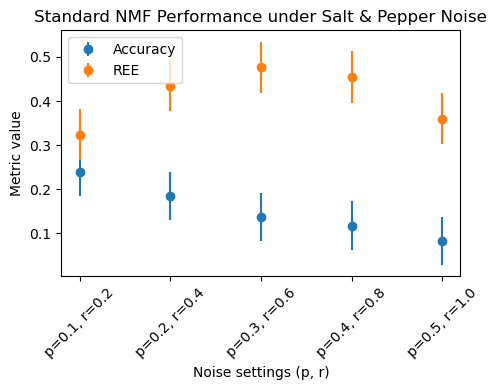

In [39]:
# Training W H on YaleB After Adding noisy
# run 5 times to get the average of Ree and Acc

acc_results = []
ree_results = []

noise_p = [0.1, 0.2, 0.3, 0.4, 0.5]
noise_r = [0.2, 0.4, 0.6, 0.8, 1.0]

iter = 350

for i in range(5):
    noisy_YaleB = aad_salt_pepper_noise(images_YaleB, noise_p[i], noise_r[i])
    result = nmf_standard(noisy_YaleB, max_iter=iter, rank=120, verbose=False)
    W1, H1, loss_list1 = result
    K = len(np.unique(labels))
    # print("unique labels:", K)

    # Ree
    REE = compute_ree(noisy_YaleB, W1, H1)
    # Accuracy
    Acc = compute_acc(labels_YaleB, H1, K)

    acc_results.append(Acc)
    ree_results.append(REE)

acc_results = np.array(acc_results)
ree_results = np.array(ree_results)

acc_mean = acc_results.mean()
acc_std = acc_results.std()
ree_mean = ree_results.mean()
ree_std = ree_results.std()
print(f"Accuracy in noised data: mean = {acc_mean:.4f}, std = {acc_std:.4f}")
print(f"REE in noised data mean = {ree_mean:.4f}, std = {ree_std:.4f}")

# visualization
x = range(len(noise_p))
plt.figure(figsize=(5, 4))

# Accuracy
plt.errorbar(x, acc_results, yerr=acc_results.std(), fmt='o', label='Accuracy')

# Ree
plt.errorbar(x, ree_results, yerr=ree_results.std(), fmt='o', label='REE')

# coordinates setting
plt.xticks(x, [f"p={p}, r={r}" for p, r in zip(noise_p, noise_r)], rotation=45)
plt.xlabel("Noise settings (p, r)")
plt.ylabel("Metric value")
plt.title("Standard NMF Performance under Salt & Pepper Noise")
plt.legend()
plt.tight_layout()
plt.show()

#
## 6.3 Run with Different Noise Levels (p, r)
- 实验参数：p = 0.2, 0.4, 0.6; r = 0.3, 0.7
- 循环运行，重复 5 次取均值和标准差
- 存储结果为表格

---


# 7. Results
## 7.1 Visualization of Original vs Noisy Images
- 绘制原始图像 + 噪声图像对比

## 7.2 Reconstruction Examples
- 展示重构前后图像（标准 NMF vs 鲁棒 NMF）

## 7.3 Quantitative Results (Tables & Graphs)
- RRE 对比表格
- Accuracy/NMI 曲线
- 不同噪声水平下的对比柱状图